# 자연어처리 과제 1 (3주차)
* 과제는 해당 .ipynb 파일에 코드 작성
    * 코드는 google colab의 gpu를 사용하는 런타임 환경에서 모두실행을 통해 한번에 실행 되어야함
    * 생성형 AI (ChatGPT, Copilot, Claude, ...) 등 사용 가능
        * 단, 사용시 사용한 방법, 입력, 출력을 캡처해 보고서에 기입
* Word를 통해 자유형식으로 보고서를 작성
    * 보고서의 양식은 자유
    * 보고서의 제출은 .pdf 형식으로 제출해야하며, 파일명은 "학번_이름_HW_??.pdf"로 제출 할 것
    * 보고서에 코드를 그대로 복붙 하지 말 것 (캡처 도구를 활용, 환경 설치 자료 참고)
* .ipynb와 .pdf 파일을 el을 통해 제출
    * 예시 : "2232036006_임상훈_HW_01.ipynb"와 "2232036006_임상훈_HW_01.pdf"를 제출

<br>

### **🔥 Wandb 관련 코드들은 전부 주석처리하고, 테스트 후 accuracy만 출력이 됩니다!** 🔥

## 1. 영어로된 영화 리뷰 데이터 전처리 (40점)

* Kaggle에서 제공하는 Movie Review Dataset(https://www.kaggle.com/datasets/vipulgandhi/movie-review-dataset?resource=download)를 전처리하여 Vocab을 구성하시오.

    * 제공되는 코드는 해당 데이터를 실습에 사용한 NSMC 데이터의 형식으로 바꾸어주는 코드이다.
        * 단, 실습과 달리 train, val, test의 세 부분으로 나누어짐
    * Vocab 구성시 Whitespace tokenizer를 사용하여야 하며, Data cleaning, Text cleaning 과정을 거치지 않은 기본 Vocab을 생성하시오

**GRADING**
* Vocab 구현에 성공(+40)

In [31]:
from pathlib import Path

raw_data_dir = "./txt_sentoken"  # 상기 링크를 통해 다운받은 데이터를 압축해제한 디렉토리 경로
data_dir = Path(raw_data_dir)

train_datas = []
val_datas = []
test_datas = []

for sentiment in ["pos", "neg"]:
    samples = list(data_dir.glob(f"{sentiment}/*.txt"))
    train_datas.extend(samples[:int(0.7 * len(samples))])
    val_datas.extend(samples[int(0.7 * len(samples)):int(0.85 * len(samples))])
    test_datas.extend(samples[int(0.85 * len(samples)):])

train_file = open("train.txt", "w")
val_file = open("val.txt", "w")
test_file = open("test.txt", "w")

for file, datas in [(train_file, train_datas), (val_file, val_datas), (test_file, test_datas)]:
    file.write("id\ttext\tlabel\n")
    for data in datas:
        lines = [line.strip() for line in data.open().readlines()]
        text = " ".join(lines)
        id = data.name[:-4]
        label = 1 if "pos" in data.parts else 0
        file.write(f"{id}\t{text}\t{label}\n")

train_file.close()
val_file.close()
test_file.close()


In [32]:
# File Open
with open("train.txt", "r") as file:
    contents = file.read()
    lines = contents.split("\n")[1:]
    train_data = [line.split("\t") for line in lines if len(line) > 0]

with open("val.txt", "r") as file:
    contents = file.read()
    lines = contents.split("\n")[1:]
    validation_data = [line.split("\t") for line in lines if len(line) > 0]

with open("test.txt", "r") as file:
    contents = file.read()
    lines = contents.split("\n")[1:]
    test_data = [line.split("\t") for line in lines if len(line) > 0]

In [33]:
# Build Your Own Vocabulary
from collections import Counter
from tqdm import tqdm

whitespace_vocab = {"[PAD]":0, "[UNK]": 1}
whitespace_vocab_idx = 2

tokenizer = lambda x: x.split()

tokenized_train_dataset = []
tokenized_validation_dataset = []
tokenized_test_dataset = []

for data in train_data:
    tokens = tokenizer(data[1])
    labels = data[2]
    tokenized_train_dataset.append((tokens, labels))

for data in validation_data:
    tokens = tokenizer(data[1])
    labels = data[2]
    tokenized_validation_dataset.append((tokens, labels))

for data in test_data:
    tokens = tokenizer(data[1])
    labels = data[2]
    tokenized_test_dataset.append((tokens, labels))

for tokens, _ in tokenized_train_dataset:
    for token in tokens:
        if token not in whitespace_vocab:
            whitespace_vocab[token] = whitespace_vocab_idx
            whitespace_vocab_idx += 1

In [34]:
print(list(whitespace_vocab.items())[:10])

[('[PAD]', 0), ('[UNK]', 1), ('i', 2), ('saw', 3), ('simon', 4), ('birch', 5), ('in', 6), ('a', 7), ('basically', 8), ('sold', 9)]


## 2. 영어로된 영화 리뷰 데이터 분류 모델 학습 (30점)
* 실습에 사용한 모델 및 Dataset 객체를 통해 긍정 부정 분류 모델을 학습하시오.
    * 실습코드와 동일한 구조의 모델을 사용해야함
    * 실습코드와 동일한 Trainer 및 하이퍼 파라미터를 유지해야함
    * Train, Validation, Test 데이터를 모두 학습에 알맞게 사용할 것

**GRADING**
* 모델 구현 및 학습 (+25)
* Train, Validation, Test를 알맞게 사용 (+5)

In [35]:
# !pip install lightning wandb

# 과제 제출용 wandb X
!pip install lightning

In [36]:
import torch
import random
import numpy as np

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

In [37]:
# Train Models
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 32)
        self.fc1 = nn.Linear(32 * 100, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(-1, 32 * 100)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [66]:
import lightning as pl

class SentimentClassifierPL(pl.LightningModule):
    def __init__(self, sentiment_classifier):
        super(SentimentClassifierPL, self).__init__()
        self.model = sentiment_classifier
        self.loss = nn.CrossEntropyLoss()

        self.validation_step_outputs = []
        self.test_step_outputs = []
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.loss(outputs, labels)
        # self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.loss(outputs, labels)
        # self.log("val_loss", loss)
        self.validation_step_outputs.append((loss, outputs, labels))
        return loss, outputs, labels

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        avg_loss = torch.stack([x[0] for x in outputs]).mean()
        # self.log("avg_val_loss", avg_loss)

        all_outputs = torch.cat([x[1] for x in outputs])
        all_labels = torch.cat([x[2] for x in outputs])
        all_preds = all_outputs.argmax(dim=1)
        accuracy = (all_preds == all_labels).float().mean()
        # self.log("val_accuracy", accuracy)
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.loss(outputs, labels)
        # self.log("test_loss", loss)
        self.test_step_outputs.append((loss, outputs, labels))
        return loss, outputs, labels

    def on_test_epoch_end(self):
        outputs = self.test_step_outputs
        avg_loss = torch.stack([x[0] for x in outputs]).mean()
        # self.log("avg_test_loss", avg_loss)

        all_outputs = torch.cat([x[1] for x in outputs])
        all_labels = torch.cat([x[2] for x in outputs])
        all_preds = all_outputs.argmax(dim=1)
        accuracy = (all_preds == all_labels).float().mean()
        # self.log("test_accuracy", accuracy)
        print('----------------------------------------')
        print('Test Accuracy : ', accuracy.item(), ' %')
        print('----------------------------------------')
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

In [39]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = int(self.data[index][1])
        tokens = self.data[index][0]

        token_ids = [self.vocab[token] if token in self.vocab else 1 for token in tokens]

        if len(token_ids) > 100:
            token_ids = token_ids[:100]
        else:
            token_ids = token_ids[:100] + [0] * (100 - len(token_ids))

        return torch.tensor(token_ids), torch.tensor(label)

In [40]:
# import wandb
from lightning.pytorch.loggers import WandbLogger

# wandb.login()

def check_vocab_properties(vocab):
    print(f"Vocab size: {len(vocab)}")
    print(f"Vocab items: {list(vocab.items())[:5]}")


def check_performance(vocab,train_data, val_data, test_data, wandb_log_name):
    # wandb_logger = WandbLogger(project="NLP", name=wandb_log_name, group="HW01")

    model = SentimentClassifier(len(vocab))
    pl_model = SentimentClassifierPL(model)

    train_dataset = SentimentDataset(train_data, vocab)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_dataset = SentimentDataset(val_data, vocab)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
    test_dataset = SentimentDataset(test_data, vocab)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    trainer = pl.Trainer(max_epochs=1,
                     accelerator="gpu",
                     # logger=wandb_logger
                     )

    trainer.fit(model=pl_model,
                train_dataloaders=train_loader,
                val_dataloaders=val_loader)

    trainer.test(dataloaders=test_loader)

    # wandb.finish()

In [41]:
check_vocab_properties(whitespace_vocab)

Vocab size: 43033
Vocab items: [('[PAD]', 0), ('[UNK]', 1), ('i', 2), ('saw', 3), ('simon', 4)]


In [42]:
check_performance(whitespace_vocab, tokenized_train_dataset, tokenized_validation_dataset, tokenized_test_dataset, "whitespace")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                | Params
----------------------------------------------
0 | model | SentimentClassifier | 1.7 M 
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.789     Total estimated model params size (MB)
INFO:lightning.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_4/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_4/checkpoints/epoch=0-step=22.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_4/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_4/checkpoints/epoch=0-step=22.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

-----------------------------
Test Accuracy :  0.49666666984558105  %
-----------------------------


## 3. Vocab 개선 (30점)
* 상기 구축한 Vocab을 최적화 하여 모델의 성능을 개선하시오
    * 남이 구축한 Vocab을 가져오는 것을 제외, 모든 것을 허용
* 참고하면 좋은 것
    * 영어의 불용어(Stopword) : https://gist.github.com/sebleier/554280
    * 영어에 적합한 Tokenizer : NLTK 라이브러리 참고 (https://www.nltk.org/api/nltk.tokenize.html)
    * 영어의 lemmatizing 및 stemming : NLTK 라이브러리를 참고 (https://www.nltk.org/api/nltk.stem.html)
    * Regular Expression 사용시 유용한 사이트 : https://regexr.com/

**GRADING**
* 수업에 배운 내용을 적용 (+10)
* 적용된 Vocab을 통해 성능 개선 (+10)
* NLTK 등 외부 라이브러리의 tokenizer 및 다양한 정규화 기법을 사용 (+10)

### 🔥 3.1 등장 빈도 확인

In [43]:
from collections import Counter

tokenizer = lambda x: x.split()

token_counter = Counter()

for tokens, _ in tokenized_train_dataset:
    token_counter.update(tokens)

In [44]:
len(token_counter)

43031

In [45]:
print(token_counter.most_common(20))
print()
print(token_counter.most_common()[-10:])

[(',', 54171), ('the', 53365), ('.', 46210), ('a', 26696), ('and', 24577), ('of', 23778), ('to', 22234), ('is', 17486), ('in', 15136), ('"', 12420), ('that', 10556), ('it', 8706), (')', 8209), ('(', 8142), ('as', 7989), ('with', 7551), ('for', 6915), ('his', 6777), ('this', 6656), ('film', 6110)]

[('-style', 1), ('ranked', 1), ('majorly', 1), ('jaunts', 1), ('shining/event', 1), ('threateningly', 1), ('appalls', 1), ("prison's", 1), ('above-par', 1), ('gorillas/live', 1)]


In [46]:
import matplotlib.pyplot as plt

def plot_frequency_distribution(counter):
    plt.plot(counter.values())
    plt.ylabel('Token Frequency')
    plt.show()

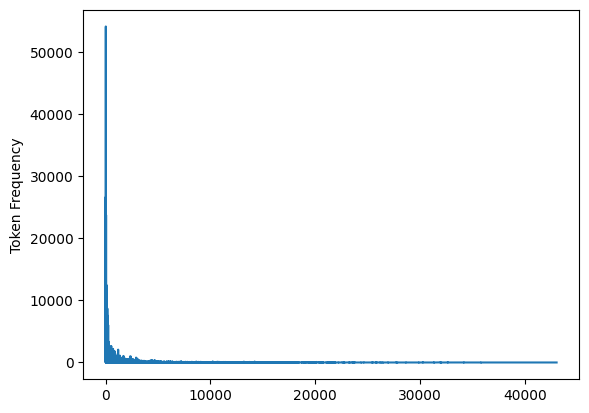

In [47]:
plot_frequency_distribution(token_counter)

- 등장빈도가 높은 상위 10개 중 대부분 불용어이다.
  - 20개로 확장해본 결과 Movie Review Data에서 `film` 의 등장빈도가 20위이다.
- 또한 `be` 로 의미가 합쳐질 수 있는 is 도 있다.
- 불용어와 문장부호, lemmatizing or stemming 을 사용해 vocab 정규화를 하고 그래프를 다시 출력해보면 좋을 것 같다.

### 🔥 3.2 문장부호 제거

In [48]:
import re

tokenizer = lambda x: x.split()

tokenzied_train_dataset = []
tokenized_validation_dataset = []
tokenzied_test_dataset = []

for data in train_data:
    text = re.sub(r'[,.!?;:()\"\'-]', ' ', data[1])
    tokens = tokenizer(text)
    labels = data[2]
    tokenzied_train_dataset.append((tokens, labels))

for data in validation_data:
    text = re.sub(r'[,.!?;:()\"\'-]', ' ', data[1])
    tokens = tokenizer(text)
    labels = data[2]
    tokenized_validation_dataset.append((tokens, labels))

for data in test_data:
    text = re.sub(r'[,.!?;:()\"\'-]', ' ', data[1])
    tokens = tokenizer(text)
    labels = data[2]
    tokenzied_test_dataset.append((tokens, labels))

token_counter = Counter()

for tokens, _ in tokenzied_train_dataset:
    token_counter.update(tokens)

In [49]:
len(token_counter)

35194

In [50]:
print(token_counter.most_common(10))
print()
print(token_counter.most_common()[-10:])

[('the', 53573), ('a', 26800), ('and', 24722), ('of', 23885), ('to', 22363), ('is', 17510), ('in', 15303), ('s', 12991), ('it', 11319), ('that', 11127)]

[('margulies', 1), ('reckoned', 1), ('fairuza', 1), ('ranked', 1), ('majorly', 1), ('jaunts', 1), ('shining/event', 1), ('threateningly', 1), ('appalls', 1), ('gorillas/live', 1)]


In [51]:
min_count = 1
cleaned_vocab = {"[PAD]":0, "[UNK]":1}
cleaned_vocab_idx = 2

for token, count in token_counter.items():
    if count > min_count:
        cleaned_vocab[token] = cleaned_vocab_idx
        cleaned_vocab_idx += 1

In [52]:
check_vocab_properties(cleaned_vocab)

Vocab size: 22043
Vocab items: [('[PAD]', 0), ('[UNK]', 1), ('i', 2), ('saw', 3), ('simon', 4)]


In [53]:
check_performance(cleaned_vocab, tokenized_train_dataset, tokenized_validation_dataset, tokenized_test_dataset, "whitespace_mc1_cleaned")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                | Params
----------------------------------------------
0 | model | SentimentClassifier | 1.0 M 
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.103     Total estimated model params size (MB)
INFO:lightning.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_5/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_5/checkpoints/epoch=0-step=22.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_5/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_5/checkpoints/epoch=0-step=22.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

-----------------------------
Test Accuracy :  0.5333333611488342  %
-----------------------------


- 문장부호를 제거하고, 등장빈도가 1회인 토큰은 제거했다.
- 성능은 약 3%정도 증가한 모습을 보인다.
- 하지만, 등장빈도 중 불용어의 비중이 높고, 의미를 합칠 수 있는 토큰도 보이기 때문에 이제 이들에 대한 처리를 해줘야한다.

### 🔥 3.3 NLTK 라이브러리 적용

In [54]:
!pip install nltk

In [56]:
# nltk resources
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### 🌈 3.3.1 NLTK word_tokenize 적용 및 불용어 제거

In [57]:
# Test word_tokenize
import nltk
from nltk.tokenize import word_tokenize

test_sentence = " a private matter  is based on the true story of sherri finkbine and the events in her life during the 1960s . after becoming pregnant ( for the fifth time ) she learns that some tranquilizers she had taken have seriously deformed her unborn child . she and her husband decide , with the help of her doctor , to have an abortion . but this is the 1960s , and abortion is illegal . her doctor has made arrangements to have the procedure performed withing the law , by claiming that the child is endangering the mother's life ."
print(word_tokenize(test_sentence))

['a', 'private', 'matter', 'is', 'based', 'on', 'the', 'true', 'story', 'of', 'sherri', 'finkbine', 'and', 'the', 'events', 'in', 'her', 'life', 'during', 'the', '1960s', '.', 'after', 'becoming', 'pregnant', '(', 'for', 'the', 'fifth', 'time', ')', 'she', 'learns', 'that', 'some', 'tranquilizers', 'she', 'had', 'taken', 'have', 'seriously', 'deformed', 'her', 'unborn', 'child', '.', 'she', 'and', 'her', 'husband', 'decide', ',', 'with', 'the', 'help', 'of', 'her', 'doctor', ',', 'to', 'have', 'an', 'abortion', '.', 'but', 'this', 'is', 'the', '1960s', ',', 'and', 'abortion', 'is', 'illegal', '.', 'her', 'doctor', 'has', 'made', 'arrangements', 'to', 'have', 'the', 'procedure', 'performed', 'withing', 'the', 'law', ',', 'by', 'claiming', 'that', 'the', 'child', 'is', 'endangering', 'the', 'mother', "'s", 'life', '.']


In [58]:
# Tokenizing & 불용어 처리
import re
from tqdm import tqdm
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

tokenized_train_dataset = []
tokenized_validation_dataset = []
tokenized_test_dataset = []

for data in tqdm(train_data):
    text = re.sub(r'[^\w\s]', ' ', data[1])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    labels = data[2]
    tokenized_train_dataset.append((tokens, labels))

for data in tqdm(validation_data):
    text = re.sub(r'[^\w\s]', ' ', data[1])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    labels = data[2]
    tokenized_validation_dataset.append((tokens, labels))

for data in tqdm(test_data):
    text = re.sub(r'[^\w\s]', ' ', data[1])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    labels = data[2]
    tokenized_test_dataset.append((tokens, labels))

100%|██████████| 300/300 [00:00<00:00, 448.32it/s]


In [59]:
token_counter = Counter()

for tokens, _ in tokenized_train_dataset:
    token_counter.update(tokens)

In [60]:
len(token_counter)

34345

In [61]:
print(token_counter.most_common(30))
print()
print(token_counter.most_common()[-10:])

[('film', 6570), ('one', 4075), ('movie', 4052), ('like', 2601), ('even', 1802), ('time', 1728), ('good', 1689), ('story', 1516), ('would', 1499), ('much', 1416), ('also', 1362), ('character', 1361), ('get', 1344), ('two', 1331), ('well', 1311), ('first', 1307), ('characters', 1261), ('way', 1214), ('see', 1195), ('make', 1160), ('little', 1085), ('films', 1083), ('life', 1082), ('really', 1070), ('people', 1058), ('plot', 1040), ('man', 996), ('could', 987), ('never', 981), ('best', 964)]

[('waspy', 1), ('julianna', 1), ('margulies', 1), ('reckoned', 1), ('fairuza', 1), ('ranked', 1), ('majorly', 1), ('jaunts', 1), ('threateningly', 1), ('appalls', 1)]


In [62]:
min_count = 1
remove_stopword_vocab = {"[PAD]":0, "[UNK]":1}
remove_stopword_vocab_idx = 2

for token, count in token_counter.items():
    if count > min_count:
        remove_stopword_vocab[token] = remove_stopword_vocab_idx
        remove_stopword_vocab_idx += 1

In [63]:
check_vocab_properties(remove_stopword_vocab)

Vocab size: 21766
Vocab items: [('[PAD]', 0), ('[UNK]', 1), ('saw', 2), ('simon', 3), ('birch', 4)]


In [64]:
check_performance(remove_stopword_vocab, tokenized_train_dataset, tokenized_validation_dataset, tokenized_test_dataset, "remove_stopword_mc1")

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'sentiment_classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['sentiment_classifier'])`.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: Fa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_6/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_6/checkpoints/epoch=0-step=22.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/

Testing: |          | 0/? [00:00<?, ?it/s]

-----------------------------
Test Accuracy :  0.5099999904632568  %
-----------------------------


- 등장빈도 상위 대부분이 불용어였기 때문에 불용어를 제거하니 성능이 개선되었다.
- 또한, 영화 리뷰 데이터에 맞는 토큰들 (ex. film, movie, story, character 등) 이 상위 등장빈도 목록에 나타나기 시작했다.
- 상위 10개만 확인해보다가 30개를 확인해보니 다음과 같은 사실을 알 수 있었다.
  - film, films와 같이 의미는 같으나 단수/복수 명사로 사용된 것
- 조금 더 넓은 범위를 확인해보면 make/made go/went와 같이 의미가 통합될 수 있는 토큰들이 존재할 것이다.

### 🌈 3.3.2 Lemmatization 적용

In [65]:
# Test of pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag

stop_words = set(stopwords.words('english'))

for data in tqdm(train_data):
    text = re.sub(r'[^\w\s]', ' ', data[1])
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    tokens = pos_tag(tokens)

print(tokens[:20])

100%|██████████| 1400/1400 [00:35<00:00, 39.62it/s]

[('instinct', 'JJ'), ('kind', 'NN'), ('movie', 'NN'), ('inexperienced', 'VBD'), ('moviegoers', 'NNS'), ('undoubtedly', 'RB'), ('label', 'VBP'), ('powerful', 'JJ'), ('touching', 'JJ'), ('name', 'NN'), ('gross', 'JJ'), ('sort', 'NN'), ('film', 'NN'), ('somebody', 'NN'), ('stands', 'VBZ'), ('bully', 'RB'), ('bully', 'RB'), ('looks', 'VBZ'), ('rebel', 'JJ'), ('threateningly', 'RB')]


- Lemmatization은 품사를 option으로 명시해주어야 조금 더 정확히 표제어를 추출할 수 있다.
- 따라서, `pos_tag` 메소드를 통해 (token, tag) 쌍을 만들어야한다.

In [67]:
# Tokenizing & 불용어 제거 & Lemmatization
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

tokenized_train_dataset = []
tokenized_validation_dataset = []
tokenized_test_dataset = []


def get_pos(tag):
    if tag.startswith('N'):
        return 'n'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('J'):
        return 'a'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n'  # default of WordNetLemmatizer's pos option is 'n'


for data in tqdm(train_data):
    text = re.sub(r'[^\w\s]', ' ', data[1])
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    tokens = pos_tag(tokens)
    lemmatized_tokens = []
    for token, tag in tokens:
        lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=get_pos(tag)))
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]
    labels = data[2]
    tokenized_train_dataset.append((lemmatized_tokens, labels))

for data in tqdm(validation_data):
    text = re.sub(r'[^\w\s]', ' ', data[1])
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    tokens = pos_tag(tokens)
    lemmatized_tokens = []
    for token, tag in tokens:
        lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=get_pos(tag)))
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]
    labels = data[2]
    tokenized_validation_dataset.append((lemmatized_tokens, labels))

for data in tqdm(test_data):
    text = re.sub(r'[^\w\s]', ' ', data[1])
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    tokens = pos_tag(tokens)
    lemmatized_tokens = []
    for token, tag in tokens:
        lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=get_pos(tag)))
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]
    labels = data[2]
    tokenized_test_dataset.append((lemmatized_tokens, labels))

100%|██████████| 300/300 [00:07<00:00, 39.40it/s]


In [68]:
token_counter = Counter()

for tokens, _ in tokenized_train_dataset:
    token_counter.update(tokens)

In [69]:
len(token_counter)

28562

In [70]:
print(token_counter.most_common(30))
print()
print(token_counter.most_common()[-10:])

[('film', 7718), ('movie', 4915), ('one', 4203), ('make', 3006), ('like', 2775), ('character', 2622), ('get', 2578), ('see', 2142), ('time', 2137), ('go', 2133), ('good', 1915), ('even', 1826), ('scene', 1780), ('well', 1728), ('story', 1638), ('play', 1566), ('take', 1543), ('would', 1499), ('much', 1416), ('come', 1374), ('also', 1362), ('way', 1355), ('two', 1331), ('give', 1319), ('first', 1307), ('look', 1305), ('know', 1303), ('end', 1294), ('seem', 1282), ('bad', 1258)]

[('boaz', 1), ('waspy', 1), ('julianna', 1), ('margulies', 1), ('reckon', 1), ('fairuza', 1), ('majorly', 1), ('sillier', 1), ('threateningly', 1), ('appall', 1)]


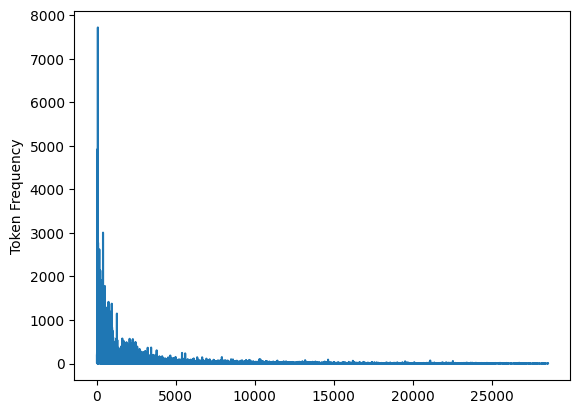

In [71]:
plot_frequency_distribution(token_counter)

In [72]:
min_count = 1
lemmatized_vocab = {"[PAD]":0, "[UNK]":1}
lemmatized_vocab_idx = 2

for token, count in token_counter.items():
    if count > min_count:
        lemmatized_vocab[token] = lemmatized_vocab_idx
        lemmatized_vocab_idx += 1

In [73]:
check_vocab_properties(lemmatized_vocab)

Vocab size: 17967
Vocab items: [('[PAD]', 0), ('[UNK]', 1), ('saw', 2), ('simon', 3), ('birch', 4)]


In [74]:
check_performance(lemmatized_vocab, tokenized_train_dataset, tokenized_validation_dataset, tokenized_test_dataset, "lemmatized_mc1")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                | Params
----------------------------------------------
0 | model | SentimentClassifier | 895 K 
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
895 K     Trainable params
0         Non-trainable params
895 K     Total params
3.581     Total estimated model params size (MB)
INFO:lightning.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_7/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_7/checkpoints/epoch=0-step=22.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_7/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_7/checkpoints/epoch=0-step=22.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

----------------------------------------
Test Accuracy :  0.5366666913032532  %
----------------------------------------


- 불용어 처리만 적용했을 때보다 성능이 개선되지는 않았지만 그래도 비슷한 성능은 보여주고 있다.

## 4. 왜 Vocab에 따라 성능이 달라지는가? (Bonus 20점)

* 실습 및 과제를 통해 Vocab에 따라 성능이 차이남을 확인할 수 있음
* 왜 성능이 하락하는지에 대한 자신의 생각을 기술하시오

**GRADING**
* 자신의 생각을 기술 함 (+10)
* 자신의 생각에 근거를 제시함 (+10)


흰트 : Vocab은 **Train 데이터를 통해서 구축**하여 Train, Validation, Test 데이터셋 모두에 사용함 + 단어가 Vocab에 없다면 **Unknown token**을 그자리에 대체함

주의! 흰트로 추론 가능한 이유 이외에도 다양한 이유가 존재. 자유롭게 기술